In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import datetime
import keras.backend as K
import time

# Set random seed for reproducibility
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()

In [2]:
# Import necessary libraries

# Start total timing
total_start_time = time.time()

# Data loading and preprocessing
print("Loading and preprocessing data...")
# Read the CSV file containing temperature data
df = pd.read_csv(r'C:\Users\ASISH JOEL\Desktop\Tube Loss\Datasets\daily-minimum-temperatures-in-me.csv')

# Clean the data by replacing problematic values with NaN
df['Daily minimum temperatures in Melbourne, Australia, 1981-1990'] = df['Daily minimum temperatures in Melbourne, Australia, 1981-1990'].replace({
    '?0.2': np.nan, 
    '?0.8': np.nan, 
    '?0.1': np.nan
})

# Convert temperature column to float type after cleaning
df['Daily minimum temperatures in Melbourne, Australia, 1981-1990'] = df['Daily minimum temperatures in Melbourne, Australia, 1981-1990'].astype(float)

# Remove any rows with missing values
df.dropna(inplace=True)

# Convert the date column to datetime format, specifying that days come before months
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Set the date column as the index of the dataframe
df.set_index('Date', inplace=True)

# Convert the dataframe to a numpy array for easier processing
df1 = df.to_numpy()


Loading and preprocessing data...


In [3]:
# Define the sequence creation function for time series data
def truncate(x, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=100, test_len=20):
    """
    Creates sliding windows of input sequences and their corresponding targets.
    
    Parameters:
        x: Input data array
        feature_cols: Columns to use as features
        target_cols: Columns to predict
        train_len: Length of input sequence
        test_len: Length of prediction sequence
        
    Returns:
        Two numpy arrays containing input sequences and their corresponding targets
    """
    in_, out_ = [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
    return np.array(in_), np.array(out_)

In [4]:
# Create sequences with 16 timesteps input and 1 timestep output
print("Creating sequences...")
X_in, X_out = truncate(df1, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=16, test_len=1)

# Split data into training and testing sets (70-30 split)
split_idx = math.floor(X_in.shape[0]*0.70)
train_x = X_in[:split_idx]
train_y = X_out[:split_idx]
test_x = X_in[split_idx:]
test_y = X_out[split_idx:]


Creating sequences...


In [5]:
# Define a custom model class for quantile regression
class QuantileModel(tf.keras.Model):
    """
    Custom model class for quantile regression with LSTM layers.
    Each instance will predict a specific quantile of the target distribution.
    """
    def __init__(self, quantile, name="quantile_model"):
        super().__init__(name=name)
        self.quantile = quantile
        
        # Define layers with unique names based on the quantile
        self.lstm1 = LSTM(16, activation='relu', 
                         return_sequences=True, 
                         name=f'lstm1_{quantile}')
        self.lstm2 = LSTM(8, activation='relu', 
                         return_sequences=False, 
                         name=f'lstm2_{quantile}')
        self.dense = Dense(1, name=f'dense_{quantile}')

    def call(self, inputs):
        x = self.lstm1(inputs)
        x = self.lstm2(x)
        return self.dense(x)

# Define the quantile loss function
def quantile_loss(quantile):
    """
    Creates a loss function for quantile regression.
    
    Parameters:
        quantile: The desired quantile (e.g., 0.975 for 97.5th percentile)
    
    Returns:
        A loss function that can be used in model compilation
    """
    def loss(y_true, y_pred):
        errors = y_true - y_pred
        return tf.reduce_mean(tf.maximum(quantile * errors, (quantile - 1) * errors), axis=-1)
    return loss

In [6]:
print("Creating and compiling models...")
# Create and compile models with unique names for upper and lower bounds
model_upper = QuantileModel(quantile=0.975, name="upper_model")
model_lower = QuantileModel(quantile=0.025, name="lower_model")

# Compile models with separate optimizer instances
model_upper.compile(
    loss=quantile_loss(0.975),
    optimizer=Adam(learning_rate=0.001),
    run_eagerly=True
)

model_lower.compile(
    loss=quantile_loss(0.025),
    optimizer=Adam(learning_rate=0.001),
    run_eagerly=True
)


Creating and compiling models...


In [7]:

# Define training parameters
epc = 300

# Train upper bound model
print("Training upper bound model...")
upper_start_time = time.time()
history_upper = model_upper.fit(
    train_x, train_y,
    validation_split=0.1,
    epochs=epc,
    verbose=1,
    batch_size=128
)
upper_end_time = time.time()
upper_training_time = upper_end_time - upper_start_time
print(f"\nUpper bound model training time: {upper_training_time:.2f} seconds")

# Clear session to ensure clean variable separation
tf.keras.backend.clear_session()

# Train lower bound model
print("\nTraining lower bound model...")
lower_start_time = time.time()
history_lower = model_lower.fit(
    train_x, train_y,
    validation_split=0.1,
    epochs=epc,
    verbose=1,
    batch_size=128
)
lower_end_time = time.time()
lower_training_time = lower_end_time - lower_start_time
print(f"\nLower bound model training time: {lower_training_time:.2f} seconds")







Training upper bound model...
Epoch 1/300
18/18 [==============================] - 2s 114ms/step - loss: 10.7558 - val_loss: 9.6748
Epoch 2/300
18/18 [==============================] - 2s 118ms/step - loss: 10.6649 - val_loss: 9.4194
Epoch 3/300
18/18 [==============================] - 2s 108ms/step - loss: 7.2865 - val_loss: 0.5017
Epoch 4/300
18/18 [==============================] - 2s 105ms/step - loss: 0.8123 - val_loss: 0.4584
Epoch 5/300
18/18 [==============================] - 2s 104ms/step - loss: 0.3199 - val_loss: 0.2840
Epoch 6/300
18/18 [==============================] - 2s 104ms/step - loss: 0.2620 - val_loss: 0.2472
Epoch 7/300
18/18 [==============================] - 2s 104ms/step - loss: 0.2485 - val_loss: 0.2376
Epoch 8/300
18/18 [==============================] - 2s 106ms/step - loss: 0.2249 - val_loss: 0.2292
Epoch 9/300
18/18 [==============================] - 2s 105ms/step - loss: 0.2114 - val_loss: 0.1996
Epoch 10/300
18/18 [==============================] - 2s 10

In [8]:
# Generate predictions
print("\nGenerating predictions...")
prediction_start_time = time.time()
y_pred_upper = model_upper.predict(test_x, verbose=0)
y_pred_lower = model_lower.predict(test_x, verbose=0)
prediction_end_time = time.time()
prediction_time = prediction_end_time - prediction_start_time



Generating predictions...


In [9]:
# Prepare data for metrics calculation
test_y_ = np.squeeze(test_y)
y_u_pred = np.squeeze(y_pred_upper)
y_l_pred = np.squeeze(y_pred_lower)

# Calculate PICP (Prediction Interval Coverage Probability)
K_u = y_u_pred > test_y_
K_l = y_l_pred < test_y_
picp = np.mean(K_u * K_l)

# Calculate MPIW (Mean Prediction Interval Width)
mpiw = np.mean(y_u_pred - y_l_pred)

# Calculate total time
total_end_time = time.time()
total_time = total_end_time - total_start_time

# Print timing summary and metrics
print("\nTiming Summary:")
print(f"Upper bound model training time: {upper_training_time:.2f} seconds")
print(f"Lower bound model training time: {lower_training_time:.2f} seconds")
print(f"Prediction time: {prediction_time:.2f} seconds")
print(f"Total execution time: {total_time:.2f} seconds")
print(f"Total execution time: {total_time/60:.2f} minutes")

print("\nModel Metrics:")
print(f'PICP: {picp:.4f}')
print(f'MPIW: {mpiw:.4f}')


Timing Summary:
Upper bound model training time: 563.83 seconds
Lower bound model training time: 571.31 seconds
Prediction time: 3.52 seconds
Total execution time: 1139.09 seconds
Total execution time: 18.98 minutes

Model Metrics:
PICP: 0.9431
MPIW: 9.1152



Generating visualizations...


Text(0, 0.5, 'Loss')

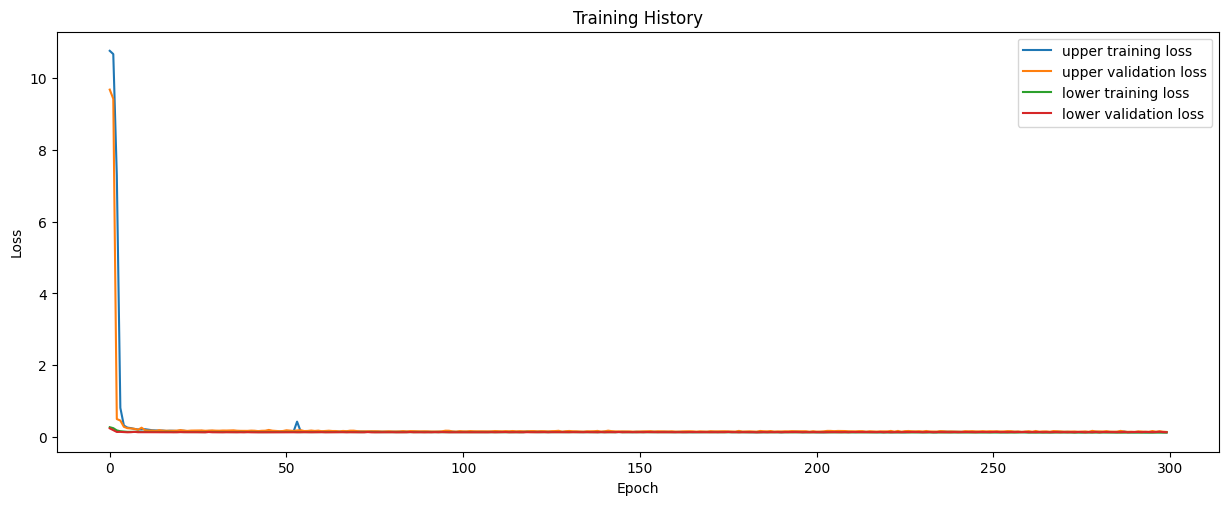

In [10]:
# Create visualization of results
print("\nGenerating visualizations...")
plt.figure(figsize=(15, 12))

# Plot training history
plt.subplot(2, 1, 1)
plt.plot(history_upper.history['loss'], label='upper training loss')
plt.plot(history_upper.history['val_loss'], label='upper validation loss')
plt.plot(history_lower.history['loss'], label='lower training loss')
plt.plot(history_lower.history['val_loss'], label='lower validation loss')
plt.legend()
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot prediction intervals

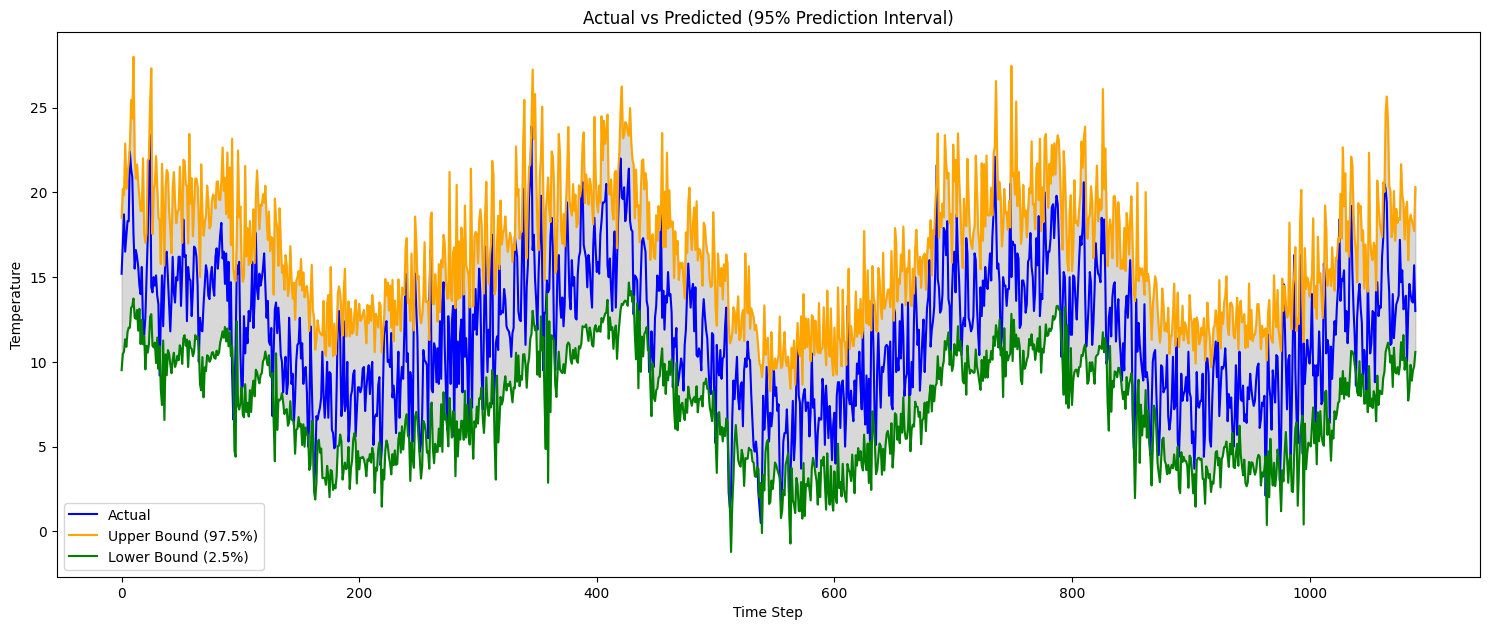


Execution completed!


In [11]:
plt.figure(figsize=(15, 12))


plt.subplot(2, 1, 2)
numEx = range(len(test_y_))
plt.plot(numEx, test_y_, label='Actual', color='blue')
plt.plot(numEx, y_u_pred, label='Upper Bound (97.5%)', color='orange')
plt.plot(numEx, y_l_pred, label='Lower Bound (2.5%)', color='green')
plt.fill_between(numEx, y_l_pred, y_u_pred, alpha=0.3, color='gray')
plt.legend(loc='best')
plt.title('Actual vs Predicted (95% Prediction Interval)')
plt.xlabel('Time Step')
plt.ylabel('Temperature')
plt.tight_layout()
plt.show()

print("\nExecution completed!")